<a href="https://colab.research.google.com/github/raminicano/SMU_GM/blob/main/link_prediction_graphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link Prediction using Graph Neural Networks
Predicts whether an edge exists between two particular nodes. e.g. social recommendation, item recommendation

The link prediction task here is formulated as a binary classification problem:
- Treat existing edges in the graph as *positive* examples
- Treat non-existing edges in the graph as *negative* examples
- Divide the *positive* and *negative* examples into  a training and test set
- Evaluate the model with Area Under Curve (AUC)

In [ ]:
!pip uninstall dgl #graph library (version을 맞춰야 함) # Deep Graph Library API
#현재 이코드는 colab에서는 안 돌아감..? -> 할 수 있는 사람 해보기

In [1]:
pip install dgl==1.1.1+cu118 -f https://data.dgl.ai/wheels/cu118/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 11.0 MB/s eta 0:00:00


In [2]:
import json # JavaScript Object Notation, 텍스트 포맷
import h5py # Hierarchical Data Format 계층구조
import time
import itertools # 이터레이터를 만드는 함수

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx
import dgl
import dgl.function as fn
from dgl.nn import SAGEConv
from sklearn.metrics import roc_auc_score


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
print("torch.version: ", torch.version.cuda)
print("device count : ", torch.cuda.device_count())

torch.version:  11.8
device count :  1


In [4]:
dgl;print(dgl.__version__) #1.1.1

1.1.1+cu118


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. GPU Connection

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))
# torch.cuda.is_available() : 현재 시스템에서 CUDA를 지원하는 GPU가 있는지 확인
# torch.device("cuda:0") : CUDA를 사용하기 위한 장치(device) 객체를 생성 (GPU 여러개일 경우 1, 2 구분)
# torch.device("cpu") : CPU를 사용하기 위한 장치(device) 객체를 생성

# 전체 코드  CUDA를 사용할 수 있는 경우에는 "cuda:0" 장치를, CUDA를 사용할 수 없는 경우에는 CPU 장치를 선택하여 device 변수에 할당


print('device : ', device) # device가 CUDA를 사용하고 있는지 확인

device :  cuda:0


# 1. Data Preparation

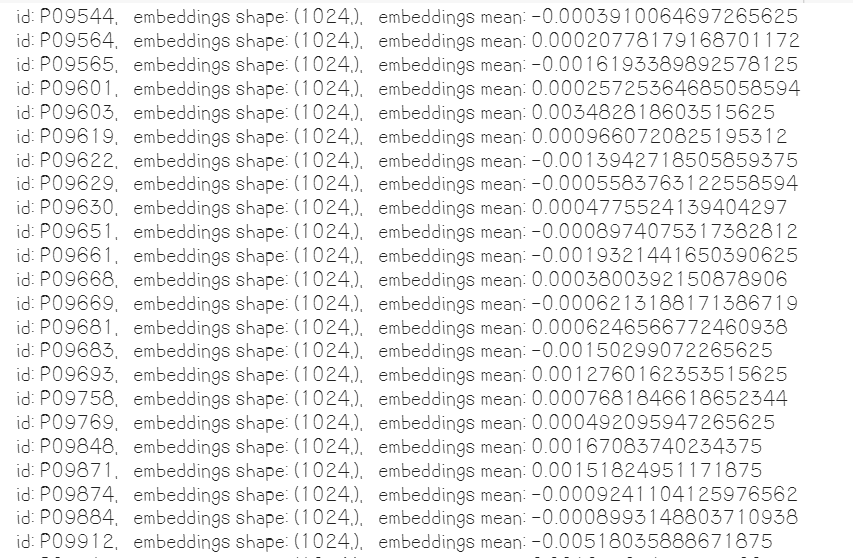

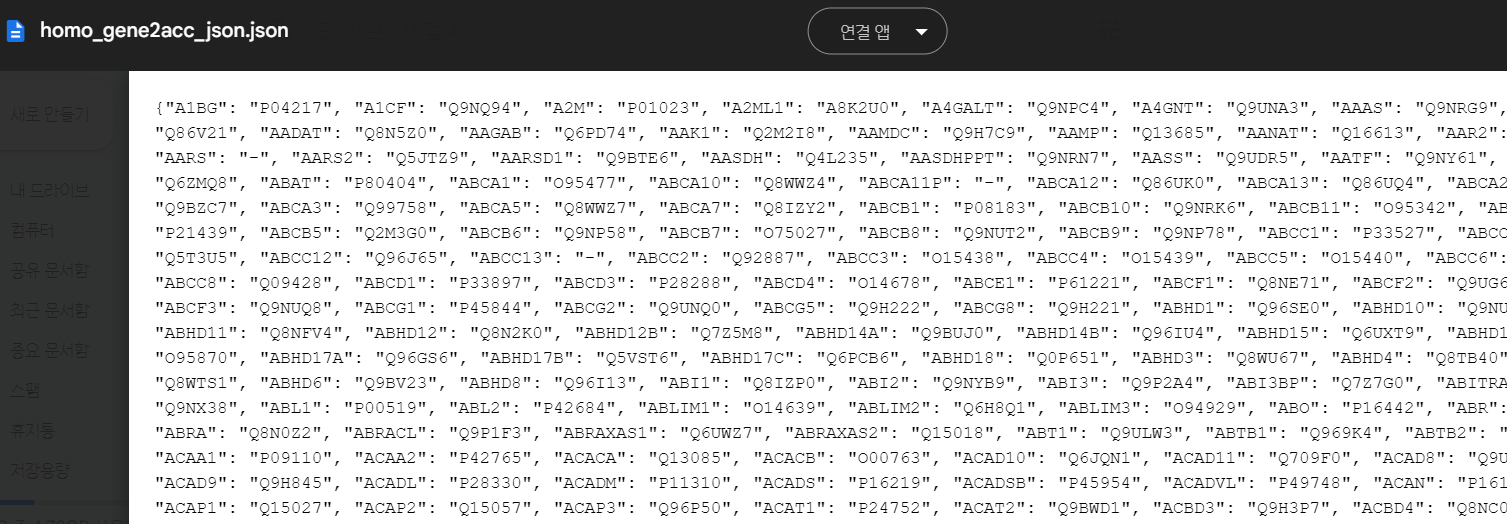

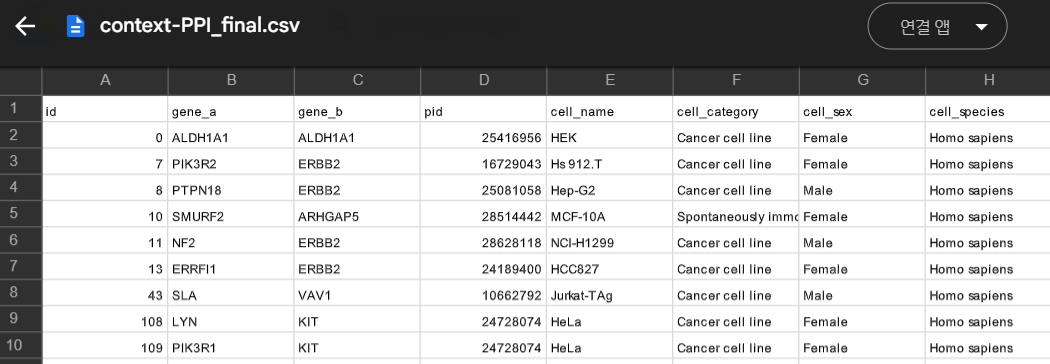

In [7]:
abs_path = '/content/drive/MyDrive/spycoder' #파일 경로 생성

In [ ]:
seq = [] # sequence_id 값을 저장
emb = [] # embedding 값을 저장
emb_mean = [] # embedding의 평균값을 저장

# with문을 사용하면 파일을 자동으로 닫아주는 기능이 있음.
with h5py.File(abs_path + "/SMWU/per-protein.h5", "r") as file: # h5py 라이브러리를 사용 HDF 파일 읽기
    print(f"number of entries: {len(file.items())}")
    for sequence_id, embedding in file.items():
        seq.append(sequence_id)
        emb.append(embedding)
        emb_mean.append(np.array(embedding).mean())
        print(
            f"  id: {sequence_id}, "
            f"  embeddings shape: {embedding.shape}, "
            f"  embeddings mean: {np.array(embedding).mean()}"
        )

In [9]:
f = open(abs_path + '/SMWU/homo_gene2acc_json.json') #JSON 파일에서 데이터를 읽어와서 처리하는 코드
gene_to_id = json.load(f) # 딕셔너리 형태로 변환하여 gene_to_id 변수에 저장 (json.load(f)는 파이썬으로 저장하는 코드)

# JSON 파일에서 유전자 ID와 시퀀스 ID를 매칭하여 평균 임베딩 값을 저장
nf_dict= {} # 결과를 저장
for i, gene in enumerate(gene_to_id): # 인덱스 i와 해당 항목의 키 gene
    gid = gene_to_id[gene] # 유전자 ID를  gene_to_id 딕셔너리에서 가져와서 gid 변수에 할당
    for j, s in enumerate(seq):  # j : seq 리스트의 인덱스 / s : seq 리스트의 값
        if gid != '-':
            if s == gid:
                nf_dict[gene] = emb_mean[j]

In [218]:
# ppi = pd.read_csv(abs_path+'/SMWU/context-PPI_final.csv').head(2000) #CSV 파일을 읽어와서 데이터프레임으로 변환 (처음 2000개 항만)
ppi = pd.read_csv(abs_path+'/SMWU/context-PPI_final.csv').head(7000)
all_nodes = list(set(list(ppi['gene_a'].unique()) + list(ppi['gene_b'].unique()))) # ppi 데이터프레임에서 'gene_a' 열과 'gene_b' 열의 고유한 값을 가져와서 중복을 제거한 후, 리스트로 변환
# set() 중복 제거
# list() 리스트로 변환

# 2. Define GNN Model
GraphSAGE in this case

In [219]:
# two-layer GraphSAGE model 로 변경
# 두 개의 레이어로 구성된 GraphSAGE 모델을 정의


class GraphSAGE(nn.Module): # nn.Module을 상속받음
    def __init__(self, in_feats, h_feats): # in_feats : 입력 특성의 차원, h_feats : 은닉 특성의 차원
        super(GraphSAGE, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출, nn.Module의 기능을 받음
        self.conv1 = SAGEConv(in_feats, h_feats, 'pool') # SAGEConv = GraphSAGE의 레이어 나타내는 클래스
        self.conv2 = SAGEConv(h_feats, h_feats, 'pool') # mean => default, pool => MaxPooling

    def forward(self, g, in_feats): # 순전파(forward pass)를 구현 (g: 그래프, in_feats : 입력 특성)
        h = self.conv1(g, in_feats) # 첫 번째 GraphSAGE 레이어에 입력 특성을 적용하여 특성을 계산,  이웃 노드의 특성을 집계하고, 결과를 h에 할당
        h = F.relu(h)  # ReLU(Rectified Linear Unit) 함수를 사용하여 활성화 함수
        h = self.conv2(g, h) # 똑같이 반복
        return h # 순전파 과정에서 계산된 최종 은닉 특성

Use `DotPredictor` or `MLP` to compute new edge features based on the original node/edge features

In [220]:
class DotPredictor(nn.Module): # DotPredictor는 간단한 선형 예측기
    def forward(self, g, h):
        with g.local_scope(): # g 객체에 대한 로컬 스코프를 생성 (특정 코드 블록에서만 유효한 변수 및 변경사항을 관리)
            g.ndata['h'] = h # 그래프 g의 노드 데이터에 'h'라는 키로 노드 특성 h를 할당

            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # g의 각 엣지에 대해 'h' 특성을 가진 소스 노드와 'h' 특성을 가진 목적 노드 간의 내적(dot-product)을 계산하여 'score'라는 새로운 엣지 특성을 계산
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module): # MLP(다층 퍼셉트론), 여러 개의 은닉층과 비선형 활성화 함수를 사용하여 입력 특성을 처리
    def __init__(self, h_feats): # h_feats는 입력 특성의 크기를 나타내는 매개변수
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats) #h_feats * 2는 입력으로 들어오는 특성의 크기를 두 배로 만들기 위해 사용
        self.W2 = nn.Linear(h_feats, 1) # 첫 번째 선형 레이어의 출력 크기인 h_feats를 고려하여 두 번째 선형 레이어를 정의, 출력 스칼라로

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1) #  src(소스 코드), dst(대상 노드)의 특징을 가르키는 벡터를 cat으로 합침
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h): #결국 classfication or regression으로 바꾸기 위해서 page 2 model이 필요~
        with g.local_scope(): #일부 그래프만 임시적으로 변경
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges) # self.apply_edges는 그래프의 edge 속성값 계산
            return g.edata['score'] #edge 스코어 반환

Create empty graph and add nodes

In [221]:
g = dgl.DGLGraph() # 빈 그래프 생성
g.add_nodes(len(all_nodes)) #node 추가

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Give each unique gene an index so as to define edges from Gene A to Gene B

In [222]:
id_dict = {}
for i, gene in enumerate(all_nodes):
    id_dict[gene] = i #gene을 키로 하고 i를 값으로

genea_idx = []
for i, gene in enumerate(ppi['gene_a']): # ppi 딕셔너리의 'gene_a' 반복하면서 노드들을 확인
    for j, idx_match in enumerate(id_dict):
        if gene == idx_match:
            genea_idx.append(id_dict[idx_match])
geneb_idx = []
for i, gene in enumerate(ppi['gene_b']): # ppi 딕셔너리의 'gene_b' 반복하면서 노드들을 확인
    for j, idx_match in enumerate(id_dict):
        if gene == idx_match:
            geneb_idx.append(id_dict[idx_match])


In [223]:
g.add_edges(torch.tensor(genea_idx).long(), torch.tensor(geneb_idx).long())

In [224]:
# nx.draw(g.to_networkx(), with_labels = True)

Create Edge and Node Features <br>
Initialize node features as zeros and use edge features to update them

In [225]:
cell_cat = torch.tensor(pd.get_dummies(ppi['cell_category']).values)
cell_sex = torch.tensor(pd.get_dummies(ppi['cell_sex']).values)
cell_spe = torch.tensor(pd.get_dummies(ppi['cell_species']).values)

In [226]:
ef = torch.cat([cell_cat, cell_sex, cell_spe], dim=-1).float()

In [227]:
feat = []
id_feat = []
ids = []
for i, gene_id in enumerate(id_dict.keys()):
    for j, gene_nf in enumerate(nf_dict.keys()):
        if gene_nf == gene_id:
            feat.append([nf_dict[gene_nf]])
            id_feat.append([id_dict[gene_id], nf_dict[gene_nf]])
            ids.append(id_dict[gene_id])

node_remove = []
for i in range(len(all_nodes)):
    if i not in ids:
        node_remove.append(i)

In [228]:
no_nf = False
if no_nf:
    g.edata['feat'] = ef
    g.ndata['_feat'] = torch.zeros(g.num_nodes(), ef.size(1))
    node_dim = g.ndata['_feat'].size(1)
    edge_dim = g.edata['feat'].size(1)
    latent_dim = 5
    node_encoder = nn.Linear(node_dim, latent_dim)
    edge_encoder = nn.Linear(edge_dim, latent_dim)
    g.ndata['_h'] = node_encoder(g.ndata['_feat'])
    g.edata['_h'] = edge_encoder(g.edata['feat'])
    g.pull(g.nodes(),
        message_func=fn.copy_e('feat', 'm'),
        reduce_func=fn.sum('m', 'feat'))
else:
    g = dgl.remove_nodes(g, node_remove)
    g.ndata['feat'] = torch.tensor(feat).float()



In [229]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(g.number_of_nodes(), g.number_of_nodes()))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [230]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [231]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [232]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

# 3. Training Methods

In [233]:
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [234]:
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# 4. Model Training

In [235]:
def compute_loss(pos_score, neg_score, device):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [240]:
# ----------- training -------------------------------- #
all_logits = []
for e in range(50):
    # forward
    train_g = train_g.to(device)
    train_pos_g = train_pos_g.to(device)
    train_neg_g = train_neg_g.to(device)

    h = model(train_g, train_g.ndata['feat']).to(device)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score, device)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))



# ----------- check results ------------------------ #
with torch.no_grad():
    test_pos_g = test_pos_g.to(device)
    test_neg_g = test_neg_g.to(device)
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.6340944170951843
In epoch 5, loss: 0.6338250637054443
In epoch 10, loss: 0.6336135864257812
In epoch 15, loss: 0.63344806432724
In epoch 20, loss: 0.6333176493644714
In epoch 25, loss: 0.6332135796546936
In epoch 30, loss: 0.6331268548965454
In epoch 35, loss: 0.6330515742301941
In epoch 40, loss: 0.6329829096794128
In epoch 45, loss: 0.6329178214073181
AUC 0.6359228936799649
